In [2]:
# import sys
# sys.path.append('./lib/python3.9/site-packages')

import csv
import folium
import io
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2


ZOOM_LEVEL = 17
R_EARTH = 6378137
CIRCUMFERENCE = 2 * np.pi * R_EARTH  # circumference of earth
mapboxAccessToken = 'pk.eyJ1IjoiemwzMTAiLCJhIjoiY2xocGplMnBrMjV5djNtcW9jbHZ3Y2IzbyJ9.eAHPD0MS19DVMGMxHV7eAQ'
PAD_FRACTION = 0.2

"""
    Calculates new latitude, longitude = y, x given old latitude and old longitude
"""


reader = csv.reader(open('../formatted_data/feature_matrix_05_08_23.csv', 'r'), delimiter=',')
next(reader)
# set your access token obtained from your mapbox account. See instructions on GitHub for more
# set tile set
mapboxTilesetId = 'mapbox.satellite'
img_size = 256

# loop through all coordinates in csv file
# for row in reader:

row = next(reader)
# extracting each cell in row individually, using my format: row = [index, longitude, latitude...]
key = (int(row[0]), float(row[2]), float(row[1]))  # row[0] is the name of the png that is saved at the end
# key = (index, latitude, longitude)
latitude, longitude = key[1], key[2]
print(key)

m = folium.Map(
    location=[row[2], row[1]],
    zoom_start=ZOOM_LEVEL,
    tiles='https://api.tiles.mapbox.com/v4/' + mapboxTilesetId + '/{z}/{x}/{y}.png?access_token=' + mapboxAccessToken,
    attr='mapbox.com')
m.save(row[2] + '.html')  # save as html file
# take screenshot of html page and save as .png file
img_data = m._to_png(4)
img = Image.open(io.BytesIO(img_data))
img = np.asarray(img)
row_len, col_len, _ = img.shape
print(row_len, col_len)
r_cent, c_cent = int(row_len / 2), int(col_len / 2)


(0, 36.0025354, -78.9374389)
683 1366


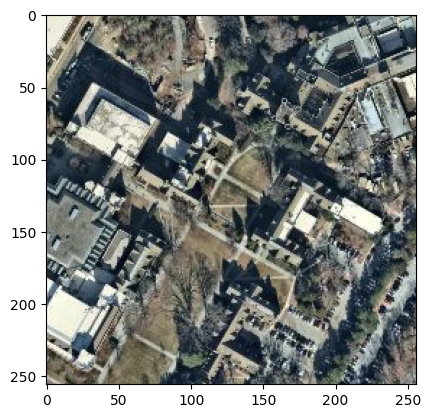

In [3]:
img_cropped = img[int(r_cent - img_size / 2):int(r_cent + img_size / 2),
                  int(c_cent - img_size / 2):int(c_cent + img_size / 2)]
plt.imshow(img_cropped)

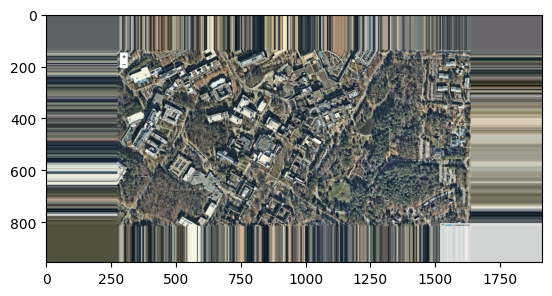

In [4]:
rrr_orig, ccc_orig, _ = img.shape
img_padded = np.pad(array=img, pad_width=((int(rrr_orig * PAD_FRACTION), int(rrr_orig * PAD_FRACTION)),
                                          (int(ccc_orig * PAD_FRACTION), int(ccc_orig * PAD_FRACTION)),
                                          (0, 0)),
                       mode='edge')
plt.imshow(img_padded)

404 975
36.0025354 -78.9374389


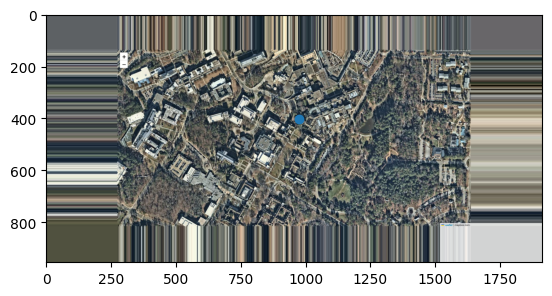

In [5]:
def new_row_col(lat_Rx, long_Rx, lat_Tx, long_Tx, pad_frac, zoom_level, orig_img_shape):
    orig_row_len, orig_col_len = orig_img_shape[0], orig_img_shape[1]
    meters_per_idx = CIRCUMFERENCE * np.cos(float(lat_Rx) * np.pi / 180) / (2 ** zoom_level) / 256
    dx = (long_Tx - long_Rx) * R_EARTH / (180 / np.pi) / np.cos(lat_Rx * np.pi / 180)
    dy = (lat_Tx - lat_Rx) * R_EARTH / (180 / np.pi)
    r = int(orig_row_len + 1 * orig_row_len * pad_frac -
            (orig_row_len / 2 + dy / meters_per_idx))
    c = int(orig_col_len / 2 + dx / meters_per_idx + orig_col_len * pad_frac)
    return r, c


test_Rx_lat, test_Rx_long = 36.003178055340896, -78.93730014070896


newr, newc = new_row_col(lat_Rx=latitude, long_Rx=longitude, lat_Tx=test_Rx_lat, long_Tx=test_Rx_long, zoom_level=ZOOM_LEVEL, pad_frac=PAD_FRACTION, orig_img_shape=(rrr_orig, ccc_orig))
print(newr, newc)
plt.imshow(img_padded)
plt.scatter(newc, newr)
print(latitude, longitude)

-167.8159889966441
327.601337033666 977.7375713609924


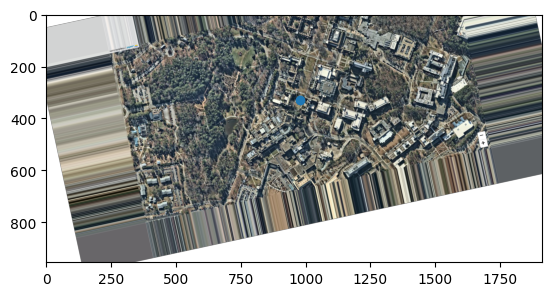

In [6]:
# def new_lat_long(old_lat, old_long, zoom_level=ZOOM_LEVEL):
#     # https://stackoverflow.com/questions/7477003/calculating-new-longitude-latitude-from-old-n-meters
#     # https://wiki.openstreetmap.org/wiki/Zoom_levels for meter_per_idx
#     meters_per_idx = CIRCUMFERENCE * np.cos(float(old_lat) * np.pi / 180) / (2 ** zoom_level) / 256
#     dx, dy = -256 / 2 * meters_per_idx, +256 / 2 * meters_per_idx
#     new_latitude = old_lat + (dy / R_EARTH) * (180 / np.pi)
#     new_longitude = old_long + (dx / R_EARTH) * (180 / np.pi) / np.cos(old_lat * np.pi / 180)
#     return new_latitude, new_longitude


def get_rotation_angle(lat_Rx, long_Rx, lat_Tx, long_Tx, data_formatted=None):
    # bs_locations_dict = get_BS_LOCATIONS_DICT()
    # bs_lat, bs_long = bs_locations_dict[data_formatted['PCI'][idx]][0:2]
    dx, dy = long_Rx - long_Tx, lat_Rx - lat_Tx
    ang = np.angle(dx + 1j * dy)
    if np.pi / 2 <= ang <= np.pi:  # quadrant II
        return np.pi / 2 - np.abs(ang)  # this is correct (provisionally)
    elif -np.pi <= ang <= -np.pi / 2:  # quadrant III
        return np.abs(ang) - 3 * np.pi / 2  # this is correct (provisionally)
    elif 0 <= ang <= np.pi / 2:  # quadrant I
        return np.pi / 2 - np.abs(ang)  # this is correct (provisionally)
    elif -np.pi / 2 <= ang <= 0:  # quadrant IV
        return np.pi / 2 + np.abs(ang)
    print("ERROR: get_rotation_angle did not return angle")
    return


def rotate_img_about_antenna(img_arr, lat_Rx, long_Rx, lat_Tx, long_Tx, pad_frac, zoom_level, orig_img_shape,
                             scale=1.0):
    """Rotates the image about the antenna."""
    # img_arr should be padded; long_centre, lat_centre are the longitude and latitude of the receiver. Rotate image such that the line connecting the user and transmitter is vertical.
    rot_matrix = get_rotation_mat(lat_Rx, long_Rx, lat_Tx, long_Tx, scale=scale, zoom_level=zoom_level,
                                  orig_img_shape=orig_img_shape, pad_frac=pad_frac)
    (h, w) = img_arr.shape[:2]
    rotated = cv2.warpAffine(img_arr, rot_matrix, (w, h))
    return rotated


def rotate_point_about_antenna(lat_Rx, long_Rx, lat_Tx, long_Tx, pad_frac, zoom_level, orig_img_shape,
                               scale=1.0, rot_matrix=None):
    # orig_img_shape=5000 using im_arr.shape
    """NOTE: rotates the point (x,y) about the antenna, not (row,col). But, the rotation is flipped in the return line, so the output is (row, col)."""
    if rot_matrix is None:
        rot_matrix = get_rotation_mat(lat_Rx, long_Rx, lat_Tx, long_Tx, scale=scale, zoom_level=zoom_level,
                                      orig_img_shape=orig_img_shape, pad_frac=pad_frac)
    point = np.ones(3)
    # long_lat_to_arr_idx returns the array index, hence we need to transform the indices
    (point[0], point[1]) = (orig_img_shape[1] / 2 + orig_img_shape[1] * pad_frac,
                            orig_img_shape[0] / 2 + orig_img_shape[0] * pad_frac)
    # swapping to (x,y) for rotation
    # transforming the shifted (x,y) location using the rotation matrix, i.e. provides (col, row) indexing into padded img
    print(np.matmul(rot_matrix, point.T)[-1], np.matmul(rot_matrix, point.T)[0])
    return np.matmul(rot_matrix, point.T)[::-1]


def get_rotation_mat(lat_Rx, long_Rx, lat_Tx, long_Tx, pad_frac, scale=1.0, zoom_level=ZOOM_LEVEL,
                     orig_img_shape=(683, 1366)):
    r_Tx, c_Tx = new_row_col(lat_Rx, long_Rx, lat_Tx, long_Tx, pad_frac=pad_frac, zoom_level=zoom_level,
                             orig_img_shape=orig_img_shape)
    # long_centre, lat_centre: longitude and latitude of the receiver
    rot_angle = (get_rotation_angle(lat_Rx, long_Rx, lat_Tx, long_Tx, data_formatted=None)) * 180 / np.pi
    # radian to degree
    # centre is the antenna, no padding
    rot_matrix = cv2.getRotationMatrix2D(center=(c_Tx,
                                                 r_Tx),
                                         angle=rot_angle, scale=scale)
    return rot_matrix


rotated_img = rotate_img_about_antenna(img_arr=img_padded, lat_Rx=latitude, long_Rx=longitude,
                                       lat_Tx=test_Rx_lat, long_Tx=test_Rx_long, pad_frac=PAD_FRACTION,
                                       orig_img_shape=(rrr_orig, ccc_orig), zoom_level=ZOOM_LEVEL)
plt.imshow(rotated_img)

print(get_rotation_angle(lat_Rx=latitude, long_Rx=longitude, lat_Tx=test_Rx_lat, long_Tx=test_Rx_long, data_formatted=None) * 180 / np.pi)

test_r, test_c = rotate_point_about_antenna(lat_Rx=latitude, long_Rx=longitude, lat_Tx=test_Rx_lat,
                                            long_Tx=test_Rx_long, pad_frac=PAD_FRACTION,
                                            orig_img_shape=(rrr_orig, ccc_orig), zoom_level=ZOOM_LEVEL)
plt.scatter(test_c, test_r)

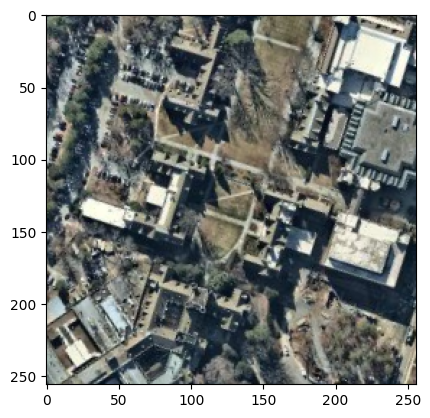

In [7]:
test_r, test_c = int(test_r), int(test_c)
plt.imshow(rotated_img[test_r-128:test_r+128, test_c-128:test_c+128])